Notebook for the analysis of transposon insertions in Hneap!! using data from the first technical replicate!

To Do List:
1. Generate figures
    1. ~~Generate function to graph insertions and essential gene distribution on genome~~
    2. ~~graph insertion density by GC~~
    3. ~~consensus sequence 20 bp on each side of insertion~~
    2. ~~graph insertion density (insertions per gene) (distplot?)~~
    3. ~~zoomed in graph of insetions near essential genes~~
    4. graph interinsertion distance distribution
    5. graph likelyhood of an insertion by position in a gene
        1. break out into esssential v non essential genes/ maybe all genes
    2. more stuff(as yet undetermined)
2. Analyse esentiality
    1. ~~generate new nStrains by counting insertions using boolean indexing & taking into acount num times seen~~
    1. figure out what pos and pos2 indicate
    1. look for confounds
        1. look for polar effects (make sure operons are not always called essential together)
        2. increased insertion/reads at origin
        3. ~~sequence motiefs~~
            1. ~~generate code to find sequence motiefs~~
            2. ~~figure out why number is way lower than should be~~
        4. ~~GC bias~~ 
        2. more stuff(as yet undetermined)
    2. normalize for any effects found (to be determined)
        1. ~~normalize for GC bias~~
    3. ~~use poison distribution to look for likely hood of gap the size of that gene~~ (after correcting nStrains by GC)
        1. might not be accurate, also look into finding variance and using the negative binomile distribution
        2. found variance over a window size, need to figure out how to look into this
    4. alternate method (from Rubin) plot insertion density (normalized insertions divided by length) and look for peaks
        1. ~~look into how they assigned probabilities to this~~
            1. I did this by treating the folded cdf as a likelihood, idk if this is accurate
        2. ~~determine how to split the two peaks for fitting~~
        3. ~~fit gamma distributions~~
        4. Address the fact that the fit gets worse when all the data is histogrammed together
    2. look for conserved genes and how this tracks with essentiallity
    5. look for carboxy cut genes and how this tracks with essentiallity
    6. look for annotated genes and how they track essentiallity
    

In [1]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from Bio.Seq import Seq
from Bio import SeqIO
from Bio import motifs
from Bio.SeqUtils import GC
import math
from scipy.optimize import curve_fit
from scipy.stats import gamma, poisson, nbinom
from sklearn.neighbors.kde import KernelDensity
from scipy.signal import argrelmin
from scipy.misc import factorial
import numpy as np
from statsmodels.discrete.discrete_model import NegativeBinomial

Populating the interactive namespace from numpy and matplotlib


In [2]:
pool_f = open("/Users/jackdesmarais/Documents/berkeley/SavageLab/scripts/HnTnSeqAnalysis/DSJD03Htn2_R1/DSJD03Htn2_S2_l006_R1_001.pool", "r")
pool_df = pd.read_table(pool_f)
pool_f.close()
unHit_f = open("/Users/jackdesmarais/Documents/berkeley/SavageLab/scripts/HnTnSeqAnalysis/DSJD03Htn2_R1/DSJD03Htn2_S2_l006_R1_001.pool.unhit", "r")
unHit_df = pd.read_table(unHit_f)
unHit_f.close()
hit_f = open("/Users/jackdesmarais/Documents/berkeley/SavageLab/scripts/HnTnSeqAnalysis/DSJD03Htn2_R1/DSJD03Htn2_S2_l006_R1_001.pool.hit", "r")
hit_df = pd.read_table(hit_f)
hit_f.close()
genes_f = open("/Users/jackdesmarais/Documents/berkeley/SavageLab/scripts/HnTnSeqAnalysis/Halo/genes.GC", "r")
genes_df = pd.read_table(genes_f)
genes_f.close()

In [3]:
pool_dropped_df =  pool_df[np.isfinite(pool_df['pos'])]

In [4]:
print("insertion pool length",len(pool_df))
print("dropped insertion pool length",len(pool_dropped_df))
print("only single insertions pool length",len(pool_dropped_df[np.invert(np.isfinite(pool_dropped_df['pos2']))]))
print("unique pos values in dropped",len(pool_dropped_df.pos.unique()))
print("unique pos values in only 1 pos",len(pool_dropped_df[np.invert(np.isfinite(pool_dropped_df['pos2']))].pos.unique()))

insertion pool length 101140
dropped insertion pool length 99429
only single insertions pool length 71788
unique pos values in dropped 71143
unique pos values in only 1 pos 55008


In [5]:
for req in SeqIO.parse("/Users/jackdesmarais/Documents/berkeley/SavageLab/scripts/HnTnSeqAnalysis/Halo/genome.fna", "fasta"):
    genome = req 

In [6]:
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█'):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print('\r%s |%s| %s%% %s' % (prefix, bar, percent, suffix), end = '\r')
    # Print New Line on Complete
    if iteration == total: 
        print()

In [7]:
insertionSites = [Seq('U'*40)]*len(pool_dropped_df.index)
pool_dropped_df["siteGC"] = [0]*len(pool_dropped_df.index)
counter = 0
smallCount = 0
largeCount = 0
normCount = 0
# points=[0]*len(pool_dropped_df.index)
for i,loc in enumerate(pool_dropped_df.index):
#     point = (pool_dropped_df.loc[loc,'pos']+pool_dropped_df.loc[loc,'pos2'])/2
    point = pool_dropped_df.loc[loc,'pos']
#     points[i]=point
#     counter+=1
#     if (counter > 48724):
#         print('infinity!!!')
#         break
    if (point<20):
        smallCount+=1
        n = math.ceil(point-20)
        site =genome[n:]+genome[:math.floor(point+20)].seq
    elif (point>len(genome)-20):
        largeCount+=1
        n = math.floor(point+20)-len(genome)
        site =genome[math.ceil(point-20):]+genome[:n].seq
    else:
        normCount+=1
        site = genome[math.ceil(point-20):math.floor(point+20)].seq
    if (pool_dropped_df.loc[loc,'strand'] == '-'):
        site = site.reverse_complement()
    insertionSites[i] = site
    printProgressBar (i+1, len(pool_dropped_df.index), prefix = 'progress', suffix = 'complete', decimals = 1, length = 50)
#     pool_dropped_df.loc[loc,"siteGC"]=GC(site)
print('smallCount:',smallCount)
print('largeCount:',largeCount)
print('normCount:',normCount)


progress |██████████████████████████████████████████████████| 100.0% complete
smallCount: 0
largeCount: 0
normCount: 99429


/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


In [8]:
# pool_dropped_df

In [9]:
lenList = [0]*len(insertionSites)
ulist = [False]*len(insertionSites)
smallCount = 0
largeCount = 0
normCount = 0
unmodCount = 0
for i, seq in enumerate(insertionSites):
    lenList[i] = len(seq)
    if (lenList[i]<40): smallCount+=1
    elif(lenList[i]>40): largeCount+=1
    elif(seq.count('U')!=0): unmodCount+=1;ulist[i]=True;
    else:normCount+=1
print('smallCount:',smallCount)
print('largeCount:',largeCount)
print('unmodCount:',unmodCount)
print('normCount:',normCount)
print('max:',max(lenList))
print('min:',min(lenList))

smallCount: 0
largeCount: 0
unmodCount: 0
normCount: 99429
max: 40
min: 40


In [11]:
m = motifs.create(insertionSites)
m.weblogo("/Users/jackdesmarais/Documents/berkeley/SavageLab/figs/HnTn02_analysis/insertionMotif")

Minimum gene length to have less than 1% chance of 0 insertions: 148.75
Minimum gene length where 0 insertions is associated with a bernolii corrected p less than 0.05: 351.25


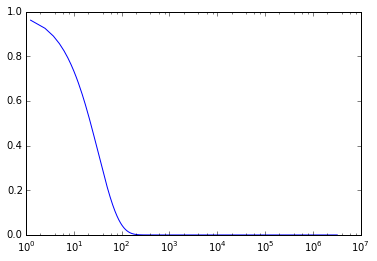

In [12]:
mu = len(pool_dropped_df.index)/len(genome)
# ntLens = range(0,2)
ntLens = list(range(1,len(genome)))
actSize = [x * (1/0.8) for x in ntLens]
mus = [x * mu for x in ntLens]
missProb = poisson.cdf(0,mus)
plt.xscale('log')
# plt.yscale('log')
plt.plot(actSize,missProb)
actSize = np.array(actSize)
geneNum = len(genes_df.index)
missProbBernolii = np.array([x * geneNum for x in missProb])
lowerThresh = max(actSize[missProb>=0.01])
upperThresh = min(actSize[missProbBernolii<=0.05])
print('Minimum gene length to have less than 1% chance of 0 insertions:',lowerThresh)
print('Minimum gene length where 0 insertions is associated with a bernolii corrected p less than 0.05:',upperThresh)
# plt.axvline(145)
# plt.axvline(340)
plt.savefig('/Users/jackdesmarais/Documents/berkeley/SavageLab/figs/HnTn02_analysis/poissonInsertionProb')

In [13]:
toMerge = genes_df.loc[:,genes_df.columns.isin(['locusId','begin','end','GC'])]
unhit_genes_df = pd.merge(unHit_df,toMerge, on='locusId')

In [14]:
# geneHits_df = genes_df.copy()
# geneHits_df.set_index('locusId', inplace=True)
# geneHits_df['nStrains'] = 0
# hitMerge_df = hit_df.set_index('locusId')
# unhitMerge_df = unhit_genes_df.set_index('locusId')
# for i,loc in enumerate(geneHits_df.index):
#     if loc in hitMerge_df.index.values[:]:
#         geneHits_df.loc[loc,'nStrains']=hitMerge_df.loc[loc,'nStrains']
#     elif loc in unhitMerge_df.index.values[:]:
#         geneHits_df.loc[loc,'nStrains']=0
#     else:
#         geneHits_df.loc[loc,'nStrains']=-1
# geneHitsDropNeg_df = geneHits_df[geneHits_df.nStrains!=-1]
# geneHitsNeg_df = geneHits_df[geneHits_df.nStrains==-1]

In [15]:
# pool_df

In [16]:
geneHits_df = genes_df.copy()
geneHits_df.set_index('locusId', inplace=True)
geneHits_df['length'] = geneHits_df.end - geneHits_df.begin
geneHits_df['nBegin'] = geneHits_df.begin + (0.1*geneHits_df['length'])
geneHits_df['nEnd'] = geneHits_df.end - (0.1*geneHits_df['length'])
geneHits_df['nStrains'] = 0

for i,loc in enumerate(geneHits_df.index):
#     (pool_df.pos>geneHits_df.loc[loc,'nBegin']) and (pool_df.pos<geneHits_df.loc[loc,'nEnd'])
    geneHits_df.loc[loc,'nStrains'] = sum((pool_df.pos>geneHits_df.loc[loc,'nBegin']) & (pool_df.n >= 10) & (pool_df.pos<geneHits_df.loc[loc,'nEnd']))
# geneHitsDropNeg_df = geneHits_df[geneHits_df.nStrains!=-1]
# geneHitsNeg_df = geneHits_df[geneHits_df.nStrains==-1]
# geneHits_df

In [17]:
# sns.distplot(geneHits_df.length,bins=50)

In [18]:
# small = geneHits_df.length.sort_values(inplace=False)
# plt.hist(geneHits_df.length,bins=50,normed=True)
# a1,b1,c1 = gamma.fit(small)
# plt.plot(small,gamma.pdf(small,a1,b1,c1))

In [19]:
geneHits_df["insertionIndex"]=geneHits_df.nStrains/(geneHits_df.length*0.8)
geneHitsOnly_df = geneHits_df[geneHits_df.nStrains!=0]

In [20]:
def plotRegress(x,y,filename):
    plt.scatter(x,y)
    gc = sm.add_constant(x)
    reg = sm.OLS(y,gc).fit()
    params = reg.params
    plt.plot(x, params.const + params.GC * x, color='r')
    print('regression line')
    plt.savefig(filename+'_regression')
    plt.show()
    print('residuals')
    plt.scatter(x,reg.resid)
    plt.savefig(filename+'_residuals')
    plt.show()
    # print(reg.params)
    print(reg.summary())
    return(reg)

In [21]:
def normalizeGC(gc,insertionIndex, filename):
    reg = plotRegress(gc,insertionIndex,filename)
    pred = reg.predict(sm.add_constant(gc))
    normalizedIndex = insertionIndex/pred
    reg2 = plotRegress(gc,normalizedIndex,filename+'Normalized')
    return(normalizedIndex)

regression line


/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


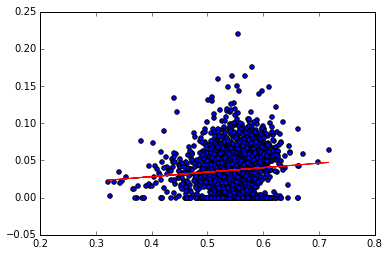

residuals


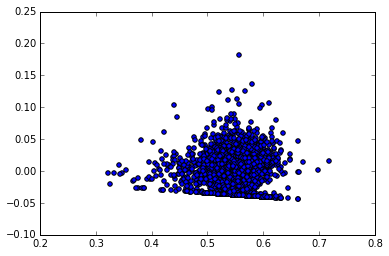

                            OLS Regression Results                            
Dep. Variable:         insertionIndex   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     17.92
Date:                Wed, 25 Oct 2017   Prob (F-statistic):           2.39e-05
Time:                        10:36:04   Log-Likelihood:                 5071.2
No. Observations:                2408   AIC:                        -1.014e+04
Df Residuals:                    2406   BIC:                        -1.013e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0041      0.008      0.521      0.6

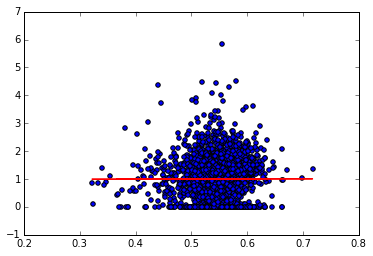

residuals


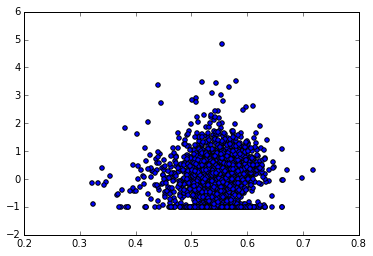

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                  0.003353
Date:                Wed, 25 Oct 2017   Prob (F-statistic):              0.954
Time:                        10:36:05   Log-Likelihood:                -2851.4
No. Observations:                2408   AIC:                             5707.
Df Residuals:                    2406   BIC:                             5718.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9878      0.210      4.699      0.0

In [22]:
geneHits_df['normalizedGCInsertions'] = normalizeGC(geneHits_df.GC,geneHits_df.insertionIndex, '/Users/jackdesmarais/Documents/berkeley/SavageLab/figs/HnTn02_analysis/GC_index')
# geneHitsDropNeg_df

regression line


/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


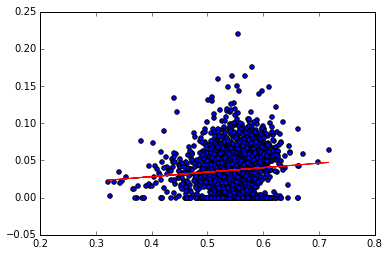

residuals


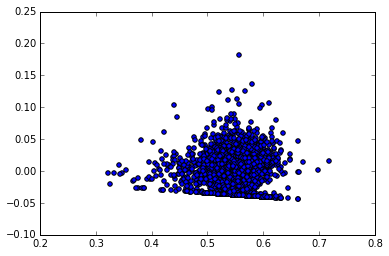

                            OLS Regression Results                            
Dep. Variable:         insertionIndex   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     17.92
Date:                Wed, 25 Oct 2017   Prob (F-statistic):           2.39e-05
Time:                        10:36:06   Log-Likelihood:                 5071.2
No. Observations:                2408   AIC:                        -1.014e+04
Df Residuals:                    2406   BIC:                        -1.013e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0041      0.008      0.521      0.6

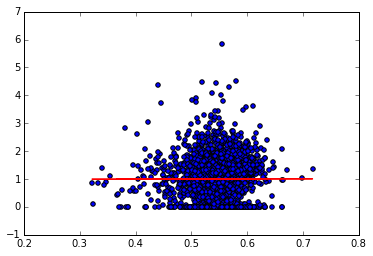

residuals


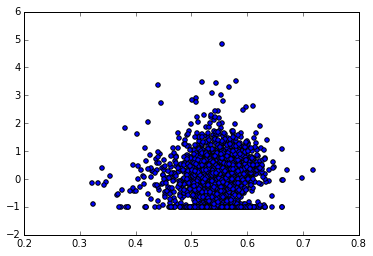

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                  0.003353
Date:                Wed, 25 Oct 2017   Prob (F-statistic):              0.954
Time:                        10:36:06   Log-Likelihood:                -2851.4
No. Observations:                2408   AIC:                             5707.
Df Residuals:                    2406   BIC:                             5718.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9878      0.210      4.699      0.0

In [23]:
geneHits_df['normalizedGCStrains'] = normalizeGC(geneHits_df.GC,geneHits_df.insertionIndex, '/Users/jackdesmarais/Documents/berkeley/SavageLab/figs/HnTn02_analysis/GC_strains')
# geneHitsDropNeg_df

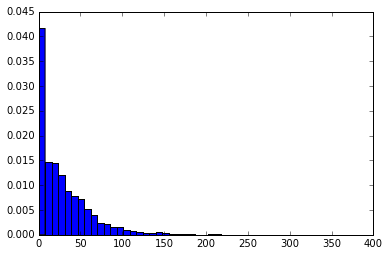

In [24]:
y,bins,p = plt.hist(geneHits_df.nStrains, bins=50,normed=True)
plt.savefig('/Users/jackdesmarais/Documents/berkeley/SavageLab/figs/HnTn02_analysis/insertionsAloneHis')
plt.show()

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/IPython/kernel/__main__.py:8: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


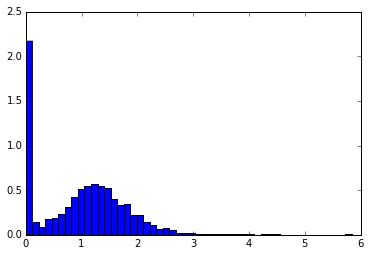

[ 661 1681 1972 2324 2350 2371 2374 2383 2390 2394 2399 2402]


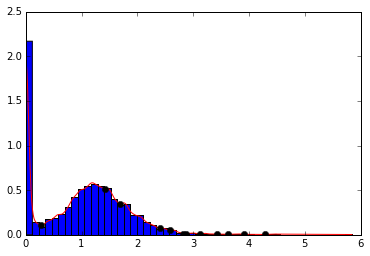

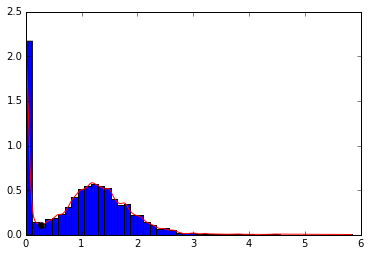

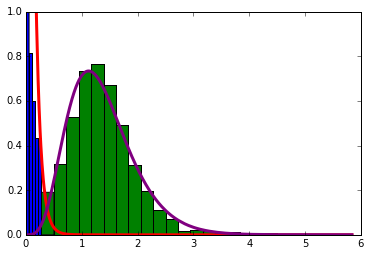

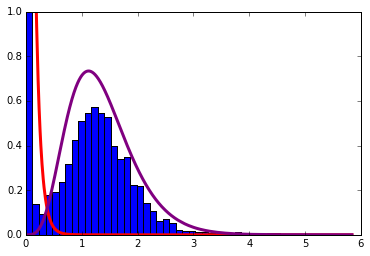

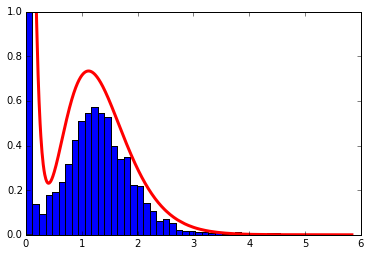

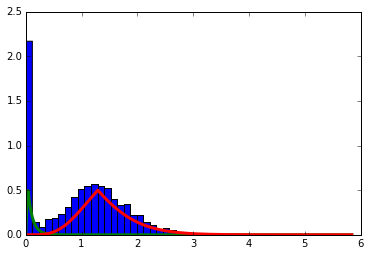

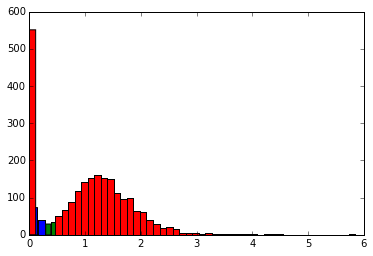

In [25]:
def likelyhood(x,a,b,c):
    return np.minimum(gamma.cdf(x,a,b,c),gamma.sf(x,a,b,c))

def gammaLogLikelyhoodRatio(x,a1,b1,c1,a2,b2,c2):
    return np.log(likelyhood(x,a1,b1,c1)/likelyhood(x,a2,b2,c2))


small = geneHits_df.normalizedGCInsertions.sort_values(inplace=False).reshape(-1, 1)
# plt.show()
y,bins,p = plt.hist(small, bins=50,normed=True)
plt.savefig('/Users/jackdesmarais/Documents/berkeley/SavageLab/figs/HnTn02_analysis/normalizedInsertionHist')
plt.show()

clf = KernelDensity(kernel='gaussian',bandwidth=0.05).fit(small)
func = np.exp(clf.score_samples(small.reshape(-1,1)))
plt.plot(small,func,'r')
val = argrelmin(func)[0]
print(val)
plt.plot(small[val],func[val],'ko')
y,bins,p = plt.hist(small, bins=50,normed=True)

plt.savefig('/Users/jackdesmarais/Documents/berkeley/SavageLab/figs/HnTn02_analysis/normalizedInsertionKde')
plt.show()

plt.plot(small,func,'r')
plt.plot(small[val[0]],func[val[0]],'ko')

# m1, m2 = clf.means_
# w1, w2 = clf.weights_
# c1, c2 = clf.covariances_ 

y,bins,p = plt.hist(small, bins=50,normed=True)
# plt.plot(small,gauss(small,m1[0],w1,c1[0][0]),color='red',lw=3,label='model')
# plt.plot(small,gauss(small,m2[0],w2,c2[0][0]),color='green',lw=3,label='model')
plt.savefig('/Users/jackdesmarais/Documents/berkeley/SavageLab/figs/HnTn02_analysis/normalizedInsertionKdeWCutSite')
plt.show()

# split = clf.predict(small)

# y,bins,p = plt.hist(small[small<0.2], bins=25,normed=True)
# y,bins,p = plt.hist(small[small>0.2], bins=25,normed=True)
# plt.ylim(0,1)


a1,b1,c1 = gamma.fit(small[:val[0]+1])
a2,b2,c2 = gamma.fit(small[val[0]:])

plt.plot(small,gamma.pdf(small,a1,b1,c1),color='red',lw=3)
plt.plot(small,gamma.pdf(small,a2,b2,c2),color='purple',lw=3)
y,bins,p = plt.hist(small[:val[0]+1], bins=5,normed=True)
y,bins,p = plt.hist(small[val[0]:], bins=25,normed=True)
plt.ylim(0,1)

plt.savefig('/Users/jackdesmarais/Documents/berkeley/SavageLab/figs/HnTn02_analysis/normalizedInsertionFitting')
plt.show()

y,bins,p = plt.hist(small, bins=50,normed=True)
# y,bins,p = plt.hist(small, bins=50,normed=False)
plt.plot(small,gamma.pdf(small,a1,b1,c1),color='red',lw=3)
plt.plot(small,gamma.pdf(small,a2,b2,c2),color='purple',lw=3)
plt.ylim(0,1)

plt.savefig('/Users/jackdesmarais/Documents/berkeley/SavageLab/figs/HnTn02_analysis/normalizedInsertionFitting2')
plt.show()

y,bins,p = plt.hist(small, bins=50,normed=True)
# y,bins,p = plt.hist(small, bins=50,normed=False)
plt.plot(small,gamma.pdf(small,a1,b1,c1)+gamma.pdf(small,a2,b2,c2),color='red',lw=3)
plt.ylim(0,1)

plt.savefig('/Users/jackdesmarais/Documents/berkeley/SavageLab/figs/HnTn02_analysis/normalizedInsertionFittingSummed')
plt.show()

y,bins,p = plt.hist(small, bins=50,normed=True)
plt.plot(small,np.minimum(gamma.cdf(small,a1,b1,c1),gamma.sf(small,a1,b1,c1)),color='green',lw=3)
plt.plot(small,np.minimum(gamma.cdf(small,a2,b2,c2),gamma.sf(small,a2,b2,c2)),color='red',lw=3)

plt.savefig('/Users/jackdesmarais/Documents/berkeley/SavageLab/figs/HnTn02_analysis/normalizedInsertionFoldCDF')
plt.show()

geneHits_df['gammaLikelyRatio']= gammaLogLikelyhoodRatio(geneHits_df.normalizedGCInsertions,a1,b1,c1,a2,b2,c2)

y,bins,p = plt.hist(geneHits_df.normalizedGCInsertions[geneHits_df.gammaLikelyRatio>2], bins=2)

y,bins,p = plt.hist(geneHits_df.normalizedGCInsertions[(geneHits_df.gammaLikelyRatio<=2)&(geneHits_df.gammaLikelyRatio>-2)], bins=2)

y,bins,p = plt.hist(geneHits_df.normalizedGCInsertions[geneHits_df.gammaLikelyRatio<=-2], bins=50)

plt.savefig('/Users/jackdesmarais/Documents/berkeley/SavageLab/figs/HnTn02_analysis/normalizedInsertionCalling')
plt.show()

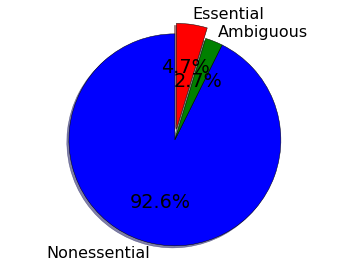

In [26]:
sns.set_context('poster')
totallen = len(geneHits_df.normalizedGCInsertions)
percNon = len(geneHits_df.normalizedGCInsertions[geneHits_df.gammaLikelyRatio<=-2])
percess = len(geneHits_df.normalizedGCInsertions[geneHits_df.gammaLikelyRatio>=2])
perMidd = len(geneHits_df.normalizedGCInsertions[(geneHits_df.gammaLikelyRatio<2)&(geneHits_df.gammaLikelyRatio>-2)])
labels='Nonessential', 'Ambiguous', 'Essential'
sizes = [percNon, perMidd, percess]
explode = (0, 0, 0.1)
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.savefig('/Users/jackdesmarais/Documents/berkeley/SavageLab/figs/HnTn02_analysis/essentialPie')
plt.show()
sns.set_context('paper')

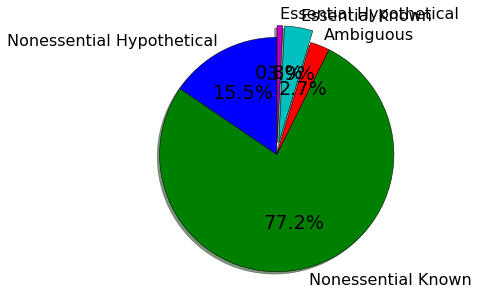

In [27]:
sns.set_context('poster')
totallen = len(geneHits_df.normalizedGCInsertions)
nonDesc = geneHits_df.desc[geneHits_df.gammaLikelyRatio<=-2]
essDesc = geneHits_df.desc[geneHits_df.gammaLikelyRatio>=2]
percNonHyp = len(nonDesc[nonDesc=="hypothetical protein"])
percessHYp = len(essDesc[essDesc=="hypothetical protein"])
percNonKn = len(nonDesc[nonDesc!="hypothetical protein"])
percessKn = len(essDesc[essDesc!="hypothetical protein"])
perMidd = len(geneHits_df.normalizedGCInsertions[(geneHits_df.gammaLikelyRatio<2)&(geneHits_df.gammaLikelyRatio>-2)])
labels='Nonessential Hypothetical', 'Nonessential Known', 'Ambiguous', 'Essential Known', 'Essential Hypothetical'
sizes = [percNonHyp, percNonKn, perMidd,percessKn, percessHYp]
explode = (0,0, 0, 0.1,0.1)
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.tight_layout()
plt.savefig('/Users/jackdesmarais/Documents/berkeley/SavageLab/figs/HnTn02_analysis/hypotheticalPie',bbox_inches='tight')
plt.show()
sns.set_context('paper')

In [28]:
# sns.set_context('poster')
# totallen = len(geneHits_df.normalizedGCInsertions)
# perchyp = len(geneHits_df.desc[geneHits_df.desc=="hypothetical protein"])
# percKn = len(geneHits_df.desc[geneHits_df.desc!="hypothetical protein"])
# labels='hypothetical', 'known'
# sizes = [perchyp, percKn]
# explode = (0, 0.1)
# fig1, ax1 = plt.subplots()
# ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
#         shadow=True, startangle=30)
# ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
# plt.savefig('/Users/jackdesmarais/Documents/berkeley/SavageLab/figs/HnTn01_analysis/hypotheticalPie')
# plt.show()
# sns.set_context('paper')

In [29]:
# def gauss(x,mu,sigma,A):
#     return A*exp(-(x-mu)**2/2/sigma**2)

# def bimodal(x,mu1,sigma1,A1,mu2,sigma2,A2):
#     return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)

# expected=(0.1,.2,250,1,.2,125)
# y,bins,patch = plt.hist(geneHits_df.normalizedGCInsertions, bins=50, align='mid')
# params,cov=curve_fit(bimodal,bins[:-1],y,expected)
# plt.plot(bins[:-1],bimodal(bins[:-1],*params),color='red',lw=3,label='model')
# plt.show()
# y,bins,patch = plt.hist(geneHits_df.normalizedGCInsertions, bins=50, align='mid')
# plt.plot(bins[:-1],gauss(bins[:-1],params[0],params[1],params[2]),color='red',lw=3,label='model')
# plt.plot(bins[:-1],gauss(bins[:-1],params[3],params[4],params[5]),color='green',lw=3,label='model')
# plt.show()
# print(params)

In [30]:
def graph_region_genes_and_insertions(regionStart,regionEnd,genes,insertions,fileName):
    sns.set_context('poster')
    ax = plt.subplot(111)
    geneRegion = genes[(genes.begin>=regionStart)&(genes.end<=regionEnd)]
    insertRegion = insertions[(insertions.pos>=regionStart)&(insertions.pos<=regionEnd)]
    for i,gene in enumerate(geneRegion.index):
        if(geneRegion.loc[gene,'strand']=='+'):
            genePic = mpl.patches.Arrow(geneRegion.loc[gene,'begin'],2,geneRegion.loc[gene,'length'],0,fill=True,facecolor='blue')
            ax.add_artist(genePic)
        else:
            genePic = mpl.patches.Arrow(geneRegion.loc[gene,'end'],2,-geneRegion.loc[gene,'length'],0,fill=True,facecolor='blue')
            ax.add_artist(genePic)
#     plt.bar(geneRegion.begin,[2]*len(geneRegion.begin),width=geneRegion.length,bottom=[1]*len(geneRegion.begin),align='edge')
    plt.ylim(0,10)
    ax.axis('off')
    plt.vlines(insertRegion.pos,[2.5]*len(insertRegion.pos),([2.5]*len(insertRegion.pos))+(insertRegion.n/max(insertRegion.n)))
    plt.savefig(fileName)
    plt.show()
    sns.set_context('paper')
    
def graph_insertions_in_gene(geneName,offset, fileName):
    plt.title(geneName)
    start=min(geneHits_df.loc[geneName,'begin'],geneHits_df.loc[geneName,'end'])-offset
    end=max(geneHits_df.loc[geneName,'begin'],geneHits_df.loc[geneName,'end'])+offset
    graph_region_genes_and_insertions(start,end,geneHits_df,pool_dropped_df,fileName)

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


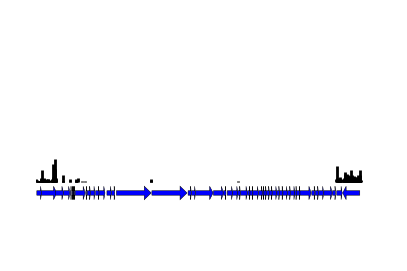

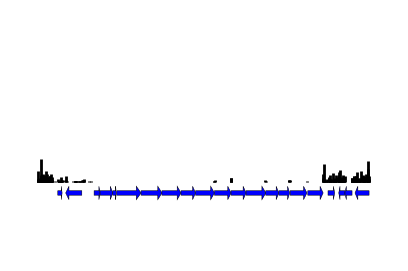

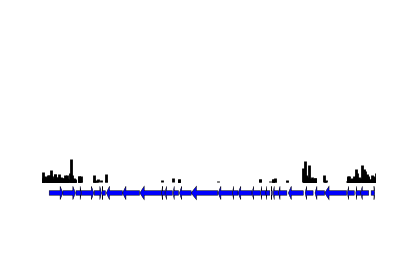

In [31]:
graph_region_genes_and_insertions(315000,355000,geneHits_df,pool_dropped_df,'/Users/jackdesmarais/Documents/berkeley/SavageLab/figs/HnTn02_analysis/gap1')
gap1 = geneHits_df[(geneHits_df.begin>=315000)&(geneHits_df.end<=355000)]
graph_region_genes_and_insertions(460000,485000,geneHits_df,pool_dropped_df,'/Users/jackdesmarais/Documents/berkeley/SavageLab/figs/HnTn02_analysis/gap2')
gap2 = geneHits_df[(geneHits_df.begin>=460000)&(geneHits_df.end<=485000)]
graph_region_genes_and_insertions(2080000,2110000,geneHits_df,pool_dropped_df,'/Users/jackdesmarais/Documents/berkeley/SavageLab/figs/HnTn02_analysis/gap3')
gap3 = geneHits_df[(geneHits_df.begin>=2080000)&(geneHits_df.end<=2110000)]

In [32]:
# gap1

In [33]:
# gap2

In [34]:
# gap3

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


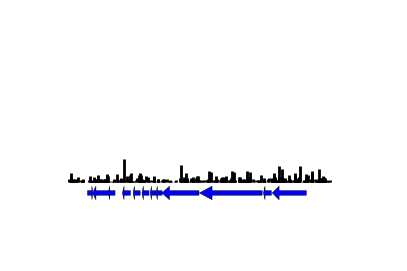

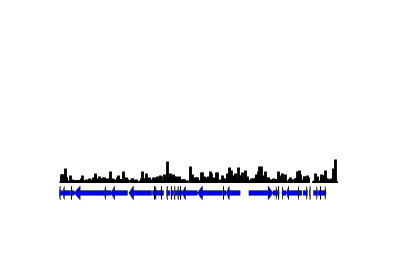

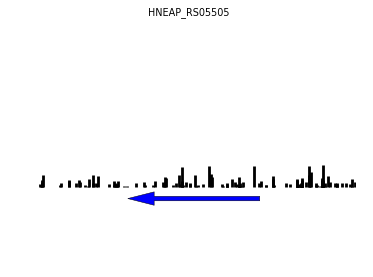

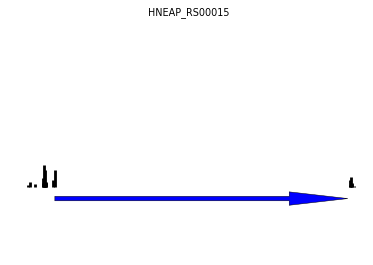

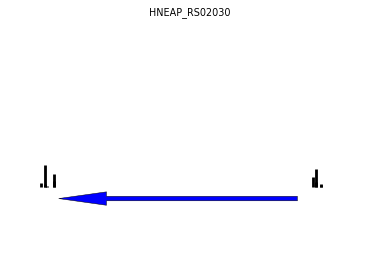

In [35]:
graph_region_genes_and_insertions(982347-1000,991279+1000,geneHits_df,pool_dropped_df,'/Users/jackdesmarais/Documents/berkeley/SavageLab/figs/HnTn02_analysis/csoOperonClose')
graph_region_genes_and_insertions(982347-10000,991279+10000,geneHits_df,pool_dropped_df,'/Users/jackdesmarais/Documents/berkeley/SavageLab/figs/HnTn02_analysis/csoOperonFar')
graph_insertions_in_gene('HNEAP_RS05505',1000,'/Users/jackdesmarais/Documents/berkeley/SavageLab/figs/HnTn02_analysis/Rubisco2')
graph_insertions_in_gene('HNEAP_RS00015',1000,'/Users/jackdesmarais/Documents/berkeley/SavageLab/figs/HnTn02_analysis/DnaA')
graph_insertions_in_gene('HNEAP_RS02030',1000,'/Users/jackdesmarais/Documents/berkeley/SavageLab/figs/HnTn02_analysis/glyceraldehyde_3_phosphate_dehydrogenase')

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


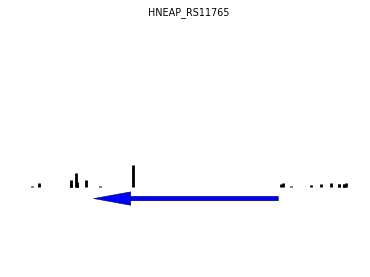

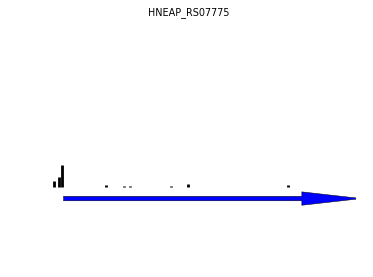

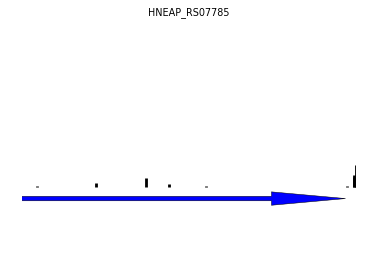

In [36]:
graph_insertions_in_gene('HNEAP_RS11765',100,'/Users/jackdesmarais/Documents/berkeley/SavageLab/figs/HnTn02_analysis/sdhSubE')
graph_insertions_in_gene('HNEAP_RS07775',100,'/Users/jackdesmarais/Documents/berkeley/SavageLab/figs/HnTn02_analysis/pyruvateDehyd')
graph_insertions_in_gene('HNEAP_RS07785',100,'/Users/jackdesmarais/Documents/berkeley/SavageLab/figs/HnTn02_analysis/GDCL')

In [37]:
# geneHits_df

In [38]:
def graph_insertions_vs_essentials(insertions,essentials, fileName):
    ax = plt.subplot(111)
    plt.ylim(-10,200)
    hist, bins = np.histogram(insertions, bins=range(0,int(max(insertions))+1000,1000))
    ax.vlines(bins, [0]*len(insertions),hist, colors='b',linewidth=1)
    length = len(essentials)
    ax.vlines(essentials, [-1]*length,[-9]*length, colors='r',linewidth=0.5)
    plt.savefig(fileName+"_linear")
    plt.show()
    
    fig = plt.figure()
    ax = plt.subplot(111, projection='polar')
    plt.ylim(-70,120)
    hist, bins = np.histogram(insertions, bins=range(0,int(max(insertions))+1000,1000))
    ax.vlines(bins, [0]*len(insertions),hist, colors='b',linewidth=1)
    length = len(essentials)
    ax.vlines(essentials, [-1]*length,[-7]*length, colors='r',linewidth=0.25)
    ax.axis('off')
    plt.savefig(fileName+"_circular")
    plt.show()

In [39]:
# d = geneHits_df[geneHits_df.gammaLikelyRatio>2]
# d.to_csv('/Users/jackdesmarais/Desktop/hnea_essetnial_genes.csv')

In [40]:
# d = geneHits_df
# d.to_csv('/Users/jackdesmarais/Desktop/hnea_genes.csv')

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


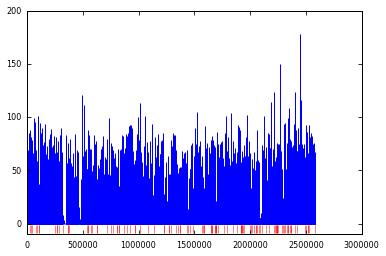

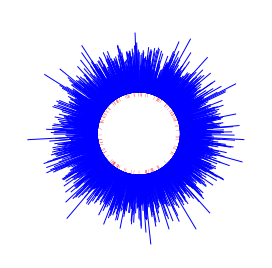

In [41]:
graph_insertions_vs_essentials(pool_dropped_df.pos.data,geneHits_df[geneHits_df.gammaLikelyRatio>2].begin.data, '/Users/jackdesmarais/Documents/berkeley/SavageLab/figs/HnTn02_analysis/gammaEsential')

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


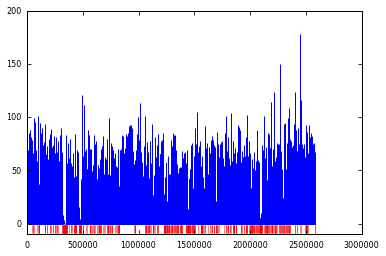

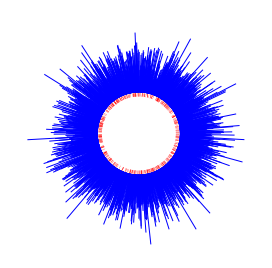

In [42]:
graph_insertions_vs_essentials(pool_dropped_df.pos.data,unhit_genes_df.begin.data, '/Users/jackdesmarais/Documents/berkeley/SavageLab/figs/HnTn02_analysis/febaUnhit')

In [32]:
# def calc_params(m,s):
#     p=1-(m/s)
#     return p,(m-m*p)/p

# ranked = sorted(pool_dropped_df.pos.data)
# distances = [0]*(len(ranked))
# for i in range(0,len(ranked)-1):
#     diff = ranked[i+1]-ranked[i]
#     distances[i] = diff
# distances[-1] = ranked[0]+len(genome)-ranked[-1]
# distances = np.array(distances).astype(int)
# counts=[0]*(max(distances)+1)
# for i in range(0,len(distances)):
#     counts[distances[i]]+=1
# x=(list(range(0,len(counts))))
# ymin = list([0]*len(counts))
# ymax = (counts)
# plt.vlines(x,ymin,ymax, colors='k',linewidth=1)

# plt.xscale('log')
# plt.yscale('log')
# plt.plot(list(range(0,len(counts))),counts)
# plt.show()
# plt.xscale('log')
# plt.yscale('log')
# normed = counts/sum(counts)
# plt.plot(list(range(0,len(normed))),normed)
# # print(distances)
# m=np.mean(distances)
# s=np.var(distances)
# print('Mean distance:',m)
# print('Median distance:',np.median(distances))
# print('Distance stdev:',np.std(distances))
# print('Distance variance:',s)
# print('Max distance:',max(distances))
# print('Min distance:',min(distances))

# p,n = calc_params(m,s)
# p1 = len(pool_dropped_df)/len(genome)
# n1 = (m-m*p1)/p1
# print('n=',n)
# print('p=',p)
# print('actual p=', p1)
# print('new n=', 11)

In [33]:
# x=list(range(0,len(distances)))
# y=distances#/sum(distances)
# y_av = pd.rolling_mean(pd.Series(y),50)
# plt.xscale('log')
# plt.yscale('log')
# plt.plot(x,nbinom.pmf(x, n, p))
# plt.hist(y,bins=100,normed=True)
# # plt.plot(x,y,'.')
# # plot(x,y_av)
# plt.show()
# # plt.xscale('log')
# # # plt.yscale('log')
# # plt.plot(x,nbinom.pmf(x, p, n))
# # plt.plot(x,y,'.')
# # plot(x,y_av)
# # plt.show()
# # plt.xscale('log')
# # # plt.yscale('log')
# # plt.plot(x,nbinom.pmf(x, n1, p1))
# # plt.plot(x,y,'.')
# # plot(x,y_av)
# # plt.show()


In [34]:
# dist = NegativeBinomial(counts,sm.tools.add_constant([1]*len(counts)), loglike_method='nb2')
# res = dist.fit()
# res.summary()

In [35]:
# res.params

In [36]:
# res.predict()

In [37]:
# # got the parameter adjustment from stack overflow... really need to figure out where it comes from
# # also, looks best when made with nb2 and corrected with nb1...

# mu = res.predict()[0]   # use this for mean if not constant
# # mu = np.exp(res.params[0])   # shortcut, we just regress on a constant
# alpha = res.params[1]
# loglike_method='nb1'
# if loglike_method == 'nb1':
#     Q = 1
# elif loglike_method == 'nb2':   
#     Q = 0

# size = 1. / alpha * mu**Q
# prob = size / (size + mu)
# print('n=',size)
# print('p=',prob)

In [38]:
# def movingaverage(interval, window_size):
#     window= np.ones(int(window_size))/float(window_size)
#     return np.convolve(interval, window, 'same')

# y_av = movingaverage(normed, 2000)


# plt.xscale('log')
# plt.yscale('log')
# plt.plot(x,nbinom.pmf(x, size, prob))
# plt.plot(list(range(0,len(normed))),normed,'.')
# plot(list(range(0,len(normed))),y_av)
# plt.show()
# plt.xscale('log')
# plt.yscale('log')
# plt.hist(normed,bins=50)
# plt.plot(x,nbinom.pmf(x, size, prob))

In [39]:
# plt.xscale('log')
# plt.yscale('log')
# plt.plot(x,nbinom.pmf(x, n, p))
# plt.plot(list(range(0,len(normed))),normed,'.')
# plt.plot(x,nbinom.pmf(x, size, prob))

In [40]:
# plt.xscale('log')
# plt.yscale('log')
# plt.plot(x,nbinom.pmf(x, p, n))
# plt.plot(list(range(0,len(normed))),normed,'.')
# plt.plot(x,nbinom.pmf(x, size, prob))

In [41]:
# plt.xscale('log')
# plt.yscale('log')
# plt.plot(x,nbinom.pmf(x, p, n))
# plt.plot(list(range(0,len(normed))),normed,'.')
# plt.plot(x,nbinom.pmf(x, size, prob))
# plt.ylim(10**-8,10**-1)

In [42]:
# plt.xscale('log')
# plt.yscale('log')
# plt.plot(x,nbinom.pmf(x, n, p))
# plt.plot(list(range(0,len(normed))),normed,'.')
# plt.plot(x,nbinom.pmf(x, size, prob))
# plt.ylim(10**-8,10**-1)

In [43]:
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█'):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print('\r%s |%s| %s%% %s' % (prefix, bar, percent, suffix), end = '\r')
    # Print New Line on Complete
    if iteration == total: 
        print()

fold=1
insertions = [0]*len(genome)
for i in range(0,len(genome),fold):
    printProgressBar(i+ 1,len(genome),prefix = 'Progress:', suffix = 'Complete', length = 50)
    if(i<=(len(genome)-1000)):
        insertions[int(i)]=len(pool_dropped_df.pos[(pool_dropped_df.pos>i)&(pool_dropped_df.pos<=(i+1000))])
    else:
        insertions[int(i)]=len(pool_dropped_df.pos[(pool_dropped_df.pos>i)&(pool_dropped_df.pos<=(i+1000-len(genome)))])
# insertions

Progress: |██████████████████████████████████████████████████| 100.0% Complete


In [44]:
# print(np.mean(insertions))
# print((len(pool_dropped_df.pos)/len(genome))*1000)
# print(np.var(insertions))

In [45]:
x=list(range(0,len(insertions)))
# plt.plot(x,insertions/sum(insertions))
# plt.hist(insertions,bins=50,normed=True)
# plt.show()

In [46]:
# small = pd.Series(insertions).sort_values(inplace=False).reshape(-1, 1)
# # plt.show()
# y,bins,p = plt.hist(small, bins=50,normed=True)
# plt.show()

# clf = KernelDensity(kernel='gaussian',bandwidth=10000).fit(small)
# func = np.exp(clf.score_samples(small))
# plt.plot(small,func,'r')
# val = argrelmin(func)[0]
# print(val)
# plt.plot(small[val],func[val],'ko')
# y,bins,p = plt.hist(small, bins=50,normed=True)


# plt.show()

# plt.plot(small,func,'r')
# plt.plot(small[val[0]],func[val[0]],'ko')

# # m1, m2 = clf.means_
# # w1, w2 = clf.weights_
# # c1, c2 = clf.covariances_ 

# y,bins,p = plt.hist(small, bins=50,normed=True)
# # plt.plot(small,gauss(small,m1[0],w1,c1[0][0]),color='red',lw=3,label='model')
# # plt.plot(small,gauss(small,m2[0],w2,c2[0][0]),color='green',lw=3,label='model')

# plt.show()

# # split = clf.predict(small)

# # y,bins,p = plt.hist(small[small<0.2], bins=25,normed=True)
# # y,bins,p = plt.hist(small[small>0.2], bins=25,normed=True)
# # plt.ylim(0,1)


# a1,b1,c1 = gamma.fit(small[:val[0]+1])
# a2,b2,c2 = gamma.fit(small[val[0]:])

# plt.plot(small,gamma.pdf(small,a1,b1,c1),color='red',lw=3)
# plt.plot(small,gamma.pdf(small,a2,b2,c2),color='purple',lw=3)
# y,bins,p = plt.hist(small[:val[0]+1], bins=5,normed=True)
# y,bins,p = plt.hist(small[val[0]:], bins=25,normed=True)
# plt.ylim(0,1)
# plt.show()

# y,bins,p = plt.hist(small, bins=50,normed=True)
# # y,bins,p = plt.hist(small, bins=50,normed=False)
# plt.plot(small,gamma.pdf(small,a1,b1,c1),color='red',lw=3)
# plt.plot(small,gamma.pdf(small,a2,b2,c2),color='purple',lw=3)
# plt.ylim(0,1)
# plt.show()

# y,bins,p = plt.hist(small, bins=50,normed=True)
# # y,bins,p = plt.hist(small, bins=50,normed=False)
# plt.plot(small,gamma.pdf(small,a1,b1,c1)+gamma.pdf(small,a2,b2,c2),color='red',lw=3)
# plt.ylim(0,1)
# plt.show()

# y,bins,p = plt.hist(small, bins=50,normed=True)
# plt.plot(small,np.minimum(gamma.cdf(small,a1,b1,c1),gamma.sf(small,a1,b1,c1)),color='green',lw=3)
# plt.plot(small,np.minimum(gamma.cdf(small,a2,b2,c2),gamma.sf(small,a2,b2,c2)),color='red',lw=3)
# plt.show()

# like = gammaLogLikelyhoodRatio(insertions,a1,b1,c1,a2,b2,c2)
# ins = pandas.Series(insertions)
# y,bins,p = plt.hist(ins[like>2], bins=2)

# y,bins,p = plt.hist(ins[(like<=2)&(geneHits_df.gammaLikelyRatio>-2)], bins=2)

# y,bins,p = plt.hist(ins[like<=-2], bins=50)

In [49]:
d = pd.DataFrame(insertions)
d.to_csv('/Users/jackdesmarais/Desktop/insertions.csv')